# Assignment 2

Akos Engelmann, Simon Jasansky

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage import color

In [3]:
# we don't need to load the y_train and y_test, as we will not use the labels of the image
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()

In [4]:
# split the test data into test and validation
data = np.concatenate((x_train, x_test))
print(data.shape)
# the shape is as expected, 60000 samples with 32x32 pictures, with 3 layers (RGB)

(60000, 32, 32, 3)


(32, 32, 3)
(32, 3)
(3,)
[0.83137256 0.06666667 0.21568628]


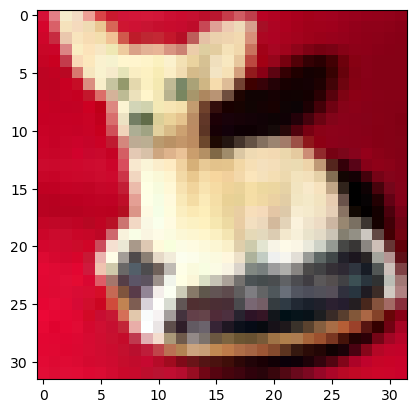

In [8]:
# first picture
print(data[0].shape)

# first row (or column, idk) of pixels of the picture
print(data[0][0].shape)

# first pixel of the first row/column of the picture (RGB values)
print(data[0][0][0].shape)
print(data[0][0][0])

# print the first picture
plt.imshow(data[0])
plt.show()

In [6]:
# reshuffle before splitting data
np.random.shuffle(data)

# do normalization over each image (use L2 norm)
data = data.astype("float32")

In [10]:
# chromacity channels (a, b in Lab, or H, S is HSV)

grey_input = list()
chrominance_output = list()

for pic in data:
    lab = color.rgb2lab(pic)
    grey_input.append(lab[:,:,0])
    chrominance_output.append(lab[:,:,1:] / 128)
    
grey_input = np.array(grey_input)
chrominance_output = np.array(chrominance_output)

# split into train, test and validation sets
ctrain = chrominance_output[:48000]
ctest = chrominance_output[48000:54000]
cvalid = chrominance_output[54000:]

gtrain = grey_input[:48000]
gtest = grey_input[48000:54000]
gvalid = grey_input[54000:]

train = data[:48000]
test = data[48000:54000]
valid = data[54000:]


In [11]:
# implement CAE
input_layer = tf.keras.layers.Input(shape=(32, 32, 1), name="INPUT")
# shape now: 32x32x1

x = tf.keras.layers.Conv2D(filters = 8, kernel_size = (3, 3), strides = 1, activation='relu', padding='same')(input_layer)
# shape now: 32x32x8

x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = 1, activation='relu', padding='same')(x)
# shape now: 32x32x64

x = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), strides = 1, activation='relu', padding='same')(x)
# shape now: 32x32x128

x = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), strides = 1, activation='relu', padding='same')(x)
# shape now: 32x32x128

x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = 1, activation='relu', padding='same')(x)
# shape now: 32x32x64

x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
#shape now: 16x16x64

x = tf.keras.layers.Conv2D(filters = 12, kernel_size = (3, 3), strides = 1, activation='relu', padding='same')(x)
#shape now: 16x16x12

x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
#shape now: 8x8x12

# Latent space is a Conv2D layer, after the MaxPooling and before the UpSampling
latent_space_rep = tf.keras.layers.Conv2D(filters = 16, kernel_size = (3, 3), strides = 1, activation='relu', padding='same', name = "LATENT_SPACE")(x)
# shape now: 8x8x16

x = tf.keras.layers.UpSampling2D((2, 2))(latent_space_rep)
# shape now: 16x16x16

x = tf.keras.layers.Conv2DTranspose(12, (3, 3), activation='relu', padding='same')(x)
# shape now: 16x16x12

x = tf.keras.layers.UpSampling2D((2, 2))(x)
# shape now: 32x32x12

x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = 1, activation='relu', padding='same')(x)
# shape now: 32x32x64

x = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), strides = 1, activation='relu', padding='same')(x)
# shape now: 32x32x128

x = tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3), strides = 1, activation='relu', padding='same')(x)
# shape now: 32x32x128

x = tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3), strides = 1, activation='relu', padding='same')(x)
# shape now: 32x32x64

output_layer = tf.keras.layers.Conv2D(2, (3, 3), padding='same', activation='tanh', name="OUTPUT")(x)
# shape now: 32x32x2

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-11-15 20:46:09.001193: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-15 20:46:09.001645: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
pic_CAE = tf.keras.models.Model(input_layer, output_layer)
pic_CAE.compile(optimizer='adam', loss='mse')
pic_CAE.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 INPUT (InputLayer)          [(None, 32, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 8)         80        
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        4672      
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0     

In [315]:
# train the model
pic_CAE.fit(x = gtrain,
           y = ctrain,
           epochs=10,
           batch_size=64,
           shuffle=True,
           validation_data=(gvalid, cvalid))

Epoch 1/10


2022-11-15 20:01:32.647739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - ETA: 0s - loss: 0.0085

2022-11-15 20:03:35.195014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - 130s 170ms/step - loss: 0.0085 - val_loss: 0.0090
Epoch 2/10
750/750 [==============================] - 123s 163ms/step - loss: 0.0083 - val_loss: 0.0090
Epoch 3/10
750/750 [==============================] - 121s 161ms/step - loss: 0.0082 - val_loss: 0.0092
Epoch 4/10
750/750 [==============================] - 121s 161ms/step - loss: 0.0080 - val_loss: 0.0094
Epoch 5/10
750/750 [==============================] - 121s 161ms/step - loss: 0.0079 - val_loss: 0.0092
Epoch 6/10
750/750 [==============================] - 121s 161ms/step - loss: 0.0078 - val_loss: 0.0093
Epoch 7/10
750/750 [==============================] - 120s 160ms/step - loss: 0.0076 - val_loss: 0.0093
Epoch 8/10
750/750 [==============================] - 120s 161ms/step - loss: 0.0075 - val_loss: 0.0093
Epoch 9/10
750/750 [==============================] - 121s 162ms/step - loss: 0.0074 - val_loss: 0.0094
Epoch 10/10
750/750 [==============================] - 125s 167ms/step - lo

In [279]:
pic_CAE.save("pic_cae_grey.h5")

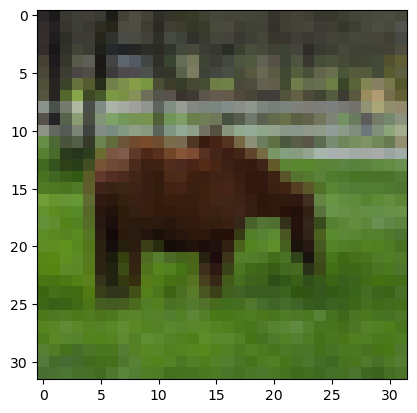

In [294]:
index = 100

plt.imshow(test[index])
plt.show()

2022-11-15 20:22:05.082256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


188/188 [==============================] - 8s 36ms/step


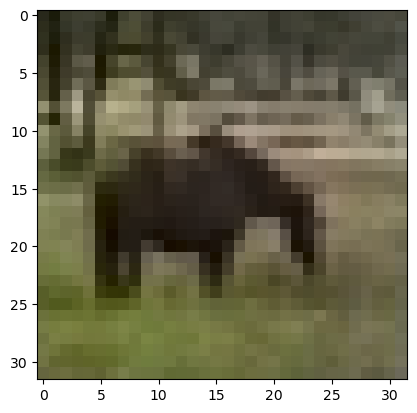

In [317]:
# get the reconstructed pics and visualize them
pics_chrominance = pic_CAE.predict(gtest)
pics_chrominance *= 128
result = np.zeros((32,32,3))
result[:,:,0] = gtest[index]
result[:,:,1:] = pics_chrominance[index]
pic = (color.lab2rgb(result)*256).round().astype(int)
pic_norm = color.lab2rgb(result)

plt.imshow(pic_norm)
plt.show()

In [318]:
results = list()
for i in range(10):
    res = np.zeros((32,32,3))
    res[:,:,0] = gtest[i]
    res[:,:,1:] = pics_chrominance[i]
    results.append(color.lab2rgb(res))

len(results)
results

[array([[[0.28405068, 0.2898965 , 0.18908031],
         [0.3769486 , 0.39330122, 0.27278825],
         [0.37070886, 0.38402318, 0.26982782],
         ...,
         [0.3721362 , 0.37537592, 0.29172261],
         [0.37262918, 0.37836175, 0.29320026],
         [0.35189469, 0.35651231, 0.24896109]],
 
        [[0.30648747, 0.31250965, 0.20040092],
         [0.38461499, 0.39612639, 0.27168213],
         [0.36970027, 0.38443021, 0.2680001 ],
         ...,
         [0.38701965, 0.38157453, 0.29703434],
         [0.38257722, 0.39037576, 0.31536671],
         [0.37518044, 0.3748471 , 0.26970482]],
 
        [[0.34799941, 0.3554758 , 0.23988809],
         [0.35349834, 0.36937909, 0.24545662],
         [0.35384735, 0.36422859, 0.24196144],
         ...,
         [0.40264599, 0.40252029, 0.31762254],
         [0.40927567, 0.41465   , 0.33524286],
         [0.42192709, 0.42359102, 0.31288486]],
 
        ...,
 
        [[0.28587604, 0.26212045, 0.22742407],
         [0.34791967, 0.32511393, 0.28686

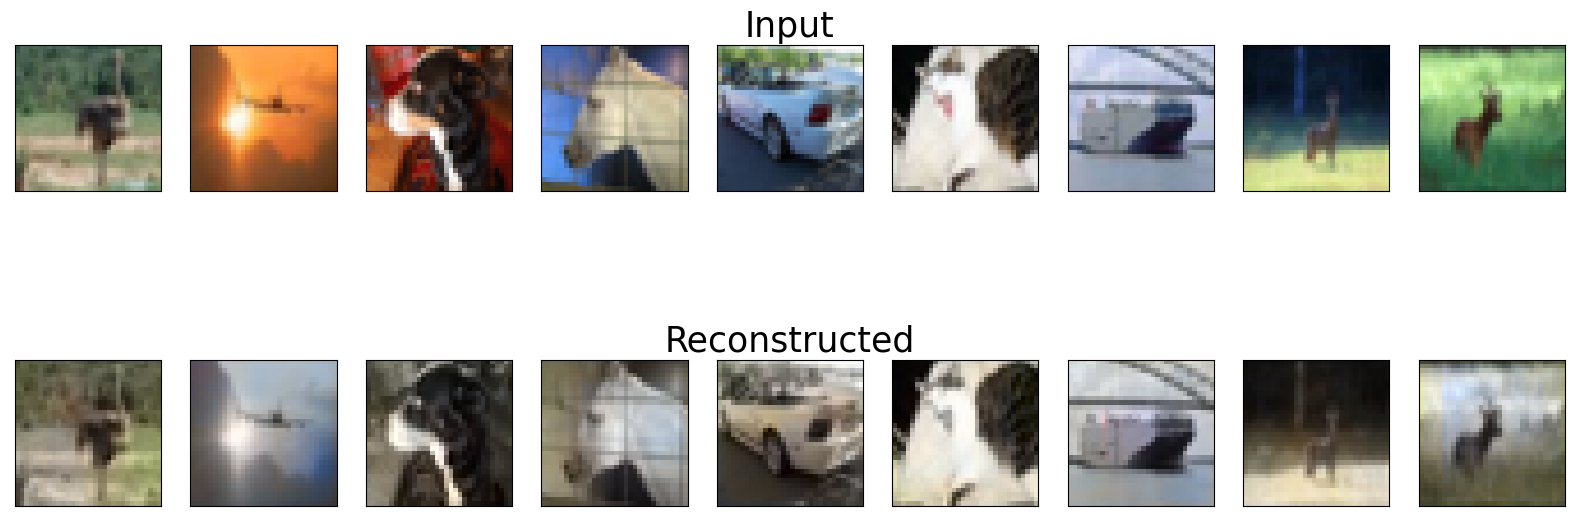

In [319]:
def plot_cae(normalized, encoded, reconstructed):
    # plot the input and reconstructed pictures
    ncols = 9
    nrows = 2

    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20, 7.5))

    for row in range(nrows):
        for col in range(ncols):
            if row == 0: # normalized
                axs[row, col].imshow(normalized[col])
                if col == 4:
                    axs[row, col].set_title("Input", size = 25)
            if row == 1: # reconstructed
                axs[row, col].imshow(reconstructed[col])
                if col == 4:
                    axs[row, col].set_title("Reconstructed", size = 25)
            axs[row, col].set_xticks([])
            axs[row, col].set_yticks([])

    plt.show()

plot_cae(test, _, results)